In [10]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
from src.tfno import FNO1d
from src.utils import relative_l2_error
from src.dataset import PDEDatasetAll2All

In [11]:
torch.manual_seed(0)
np.random.seed(0)

In [12]:
DEVICE = "mps"

In [13]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True))

<All keys matched successfully>

# Evaluating the model for the bonus task 

### Evaluating on test data at different time intervals

In [14]:
dataset_test = PDEDatasetAll2All(
    "data/test_sol.npy",
    device=DEVICE,
    time_pairs=[(0, 1), (0, 2), (0, 3), (0, 4)],
)
test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [15]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)
losses = {}

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
        time_delta = dt.item()

        if time_delta not in losses:
            losses[time_delta] = []
        losses[time_delta].append(loss.item())
        
    test_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error (OOD Dataset): {test_relative_l2}")

100%|██████████| 512/512 [00:06<00:00, 80.98it/s]

Test relative L2 error (OOD Dataset): 0.4052711351250764


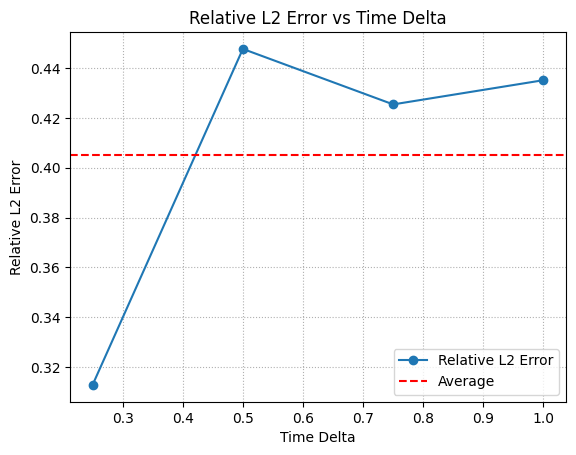

In [16]:
dts = []
means = []
for dt, ls in sorted(losses.items()):
    dts.append(dt)
    means.append(np.mean(ls))

plt.plot(dts, means, marker="o", label="Relative L2 Error")

# draw horizontal line for average
plt.axhline(y=test_relative_l2, color="r", linestyle="--", label="Average")

plt.xlabel("Time Delta")
plt.ylabel("Relative L2 Error")
plt.title("Relative L2 Error vs Time Delta")
plt.grid(True, ls=":")
plt.legend()
plt.show()

### OOD Dataset

In [17]:
dataset_ood = PDEDatasetAll2All(
    "data/test_sol_OOD.npy",
    device=DEVICE,
)
ood_data_loader = DataLoader(dataset_ood, batch_size=1, shuffle=True)

In [18]:
fno.eval()
progress_bar = tqdm.tqdm(ood_data_loader)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        ood_relative_l2 += loss.item()
    ood_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error (OOD Dataset): {ood_relative_l2}")

100%|██████████| 128/128 [00:01<00:00, 83.69it/s]

Test relative L2 error (OOD Dataset): 0.1273320364416577
